In [1]:
# package(s) related to time, space and id
import datetime

# Used for mathematical functions
import math
import platform
import time

import matplotlib.pyplot as plt

# Used for making the graph to visualize our problem
import networkx as nx

# package(s) for data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
# spatial libraries
import pyproj
import shapely.geometry

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
from simplekml import Kml, Style

## U_rel calculation and plotting starts from here 
- define function
- set input value
- arrange input table
- use the defined function and get output table
- select desired variables for plotting

#### define function

In [2]:
# Shallow water factor
def get_swf (T, h):
    r = h/T
    swf = 1/(1-np.exp(4*(1-max([r, 1.1]))))
    return swf

# Adjusted velocity 
def get_Vadj (Bs, Bc, V, T, h, Ls, swf):
   
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    r = h/T
    
    #get limit speed 1
    if 0.1<=Blockage<=0.3:
        Vlim = 0.78 * (np.sqrt(h*9.81)) * ((1 - Blockage)**2.25)
    else:
        #Vlim = (np.sqrt(8*h*9.81))* (np.cos((np.pi + (np.cos(1- Blockage))**(-1)))/3)**1.5
        #Vlim = np.sqrt (9.81*Ls/2*np.pi)
        Vlim = np.sqrt (9.81*h)
        

    # get shallow speed     
    r = h/T
    Vsh = 1.18 * V * (swf**(-0.75 - Blockage))
    
    #get adjusted velocity
    if Vsh <= 0.9 * Vlim and Vsh < V:
        Vadj = Vsh
    if V < 0.9 * Vlim and V < Vsh:
        Vadj = V 
    else:
        Vadj =min([V, 0.9 * Vlim, Vsh ])
    return r, Vadj

# Return current speed 
def get_Ur (Bs, Bc, Vadj, T, h):
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get Froude number
    Frh = Vadj / np.sqrt(h * 9.81)
    Ur = (Blockage * Vadj)/(1-(Blockage)-(Frh**2))
    
    return Ur

# Relative velocity
def get_Urel (h, T, Ur, Vadj, swf): 
    Unarrow = Ur + Vadj
    Ushallow = swf * Vadj
    Urel = max([Unarrow, Ushallow])
    
    return Urel, Unarrow, Ushallow


####Rf
def get_Rf (Bs, Urel, T, Ls):
    
    # get cf
    Re = (Urel*Ls)/ (10**(-6))
    cf = 0.053 /((np.log10(Re)-2)**2)
    
    Rf = 1.4*0.5 *(Urel**2) * cf * (Bs *Ls + 2 * Ls * T)
    return  Rf

####Rp
def get_Rp (Vadj, T):
    Rp = 0.5 *(Vadj**2) * 0.15 * (Bs * T)
    return Rp

####Rz
def get_Rz (Bs, Bc, T, h, Vadj):
    
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get Froude number
    Frh = Vadj / np.sqrt(h*9.81)
    
    #get z
    z = (Blockage/(1-Blockage-(Frh**2))) * (Frh**2) * h
    
    Rz = 9.81 *z * 0.2 * (Bs * T)
    return Rz

####Rtot
def get_Rtot(Rp, Rf, Rz):
    
    Rtot =  Rp + Rf + Rz
    return Rtot

# Power estimation 
# BHP > DHP > EHP
# 1) Effective horse power Pe (Power needed to overcome the total drag)
def get_Pe ():
    Pe = Vadj * Rtot
    return Pe

# 2) Delivered horse power Pd (Power delivered to the propeller shaft)
def get_Pd ():
    Pd = (Urel * Rtot)/ 0.55
    return Pd

# 3) Brake horse power or Propulsion power Pb (Required motor power)
def get_Pb ():
    Pb = 2*Pd
    return Pb

###Energy consumption
def get_Energy (Urel, Rtot, V):
    #rel = Urel / V
    E = 2 * 0.001 * Rtot * ( Urel / V) * 1852
    return E

#### input value for Urel

In [3]:
# M8 motor vessel
h = np.linspace(4,10,25)  # water depth from 3 m to 10 m is a suitable range for the Ductch waterways 
h_more = np.linspace(4,10,25)
V_more = np.linspace(0,6,25)
Bs = [11.4]
Bc= [150] 
V = [3]
T = [2.7]
Ls = [110]

#### prepare input matrix for calculation

In [4]:
h_more = np.linspace(3,10,29)
h_more

array([ 3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,
        5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,
        7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,
        9.75, 10.  ])

In [5]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product( h_more, Bs, Bc, V_more, T, Ls, ))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"h_more": item[0],"Bs": item[1], "Bc": item[2], "V_more": item[3], "T": item[4], "Ls": item[5]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(50)

,h_more,Bs,Bc,V_more,T,Ls
0,3.00,11.4,150,0.00,2.7,110
1,3.00,11.4,150,0.25,2.7,110
2,3.00,11.4,150,0.50,2.7,110
3,3.00,11.4,150,0.75,2.7,110
4,3.00,11.4,150,1.00,2.7,110
5,3.00,11.4,150,1.25,2.7,110
6,3.00,11.4,150,1.50,2.7,110
7,3.00,11.4,150,1.75,2.7,110
8,3.00,11.4,150,2.00,2.7,110
9,3.00,11.4,150,2.25,2.7,110


#### use the defined function and get output table

In [6]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    h = row['h_more']
    Bs = row['Bs']
    Bc = row['Bc']
    V = row['V_more']
    T = row['T']
    Ls = row['Ls']

    swf =  get_swf (T, h)
    r, Vadj = get_Vadj(Bs, Bc, V, T, h, Ls, swf)
    Ur = get_Ur(Bs, Bc, Vadj, T, h)
    Urel, Unarrow, Ushallow = get_Urel (h, T, Ur, Vadj, swf)
    Rf = get_Rf(Bs, Urel, T, Ls)
    Rp = get_Rp(Vadj, T)
    Rz = get_Rz (Bs, Bc, T, h, Vadj)
    Rtot = get_Rtot(Rp, Rf, Rz)
    Pe = get_Pe ()
    Pd = get_Pd ()
    Pb = get_Pb ()
    E = get_Energy(Urel, Rtot, V)


        
    result = {}
    result.update(row)
    result['h/T'] = r
    result['Vadj'] = Vadj
    result['Ur'] = Ur
    result['Urel'] = Urel
    result['Unarrow'] = Unarrow
    result['Ushallow'] = Ushallow
    result['Rf'] = Rf
    result['Rp'] = Rp
    result['Rz'] = Rz
    result['Rtot']= Rtot
    result['Pe'] = Pe
    result['Pb'] = Pb
    result['Pd'] = Pd
    result ['E'] = E

    results.append(result)

plot_df = pd.DataFrame(results)

plot_df.head(20)

0it [00:00, ?it/s]C:\Users\30698\AppData\Local\Temp\ipykernel_10828\930240813.py:64: RuntimeWarning: divide by zero encountered in log10
  cf = 0.053 /((np.log10(Re)-2)**2)
C:\Users\30698\AppData\Local\Temp\ipykernel_10828\930240813.py:117: RuntimeWarning: invalid value encountered in double_scalars
  E = 2 * 0.001 * Rtot * ( Urel / V) * 1852
725it [00:00, 10417.54it/s]


,h_more,Bs,Bc,V_more,T,Ls,h/T,Vadj,Ur,Urel,Unarrow,Ushallow,Rf,Rp,Rz,Rtot,Pe,Pb,Pd,E
0,3.0,11.4,150.0,0.00,2.7,110.0,1.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,3.0,11.4,150.0,0.25,2.7,110.0,1.111111,0.127507,0.009367,0.355350,0.136874,0.355350,0.276852,0.037531,0.007353,0.321736,0.041023,0.415741,0.207871,1.693896
2,3.0,11.4,150.0,0.50,2.7,110.0,1.111111,0.255013,0.018768,0.710700,0.273781,0.710700,0.997159,0.150126,0.029463,1.176748,0.300086,3.041146,1.520573,6.195422
3,3.0,11.4,150.0,0.75,2.7,110.0,1.111111,0.382520,0.028236,1.066050,0.410756,1.066050,2.115304,0.337783,0.066490,2.519577,0.963788,9.767258,4.883629,13.265239
4,3.0,11.4,150.0,1.00,2.7,110.0,1.111111,0.510026,0.037806,1.421401,0.547832,1.421401,3.610365,0.600503,0.118700,4.329568,2.208194,22.378368,11.189184,22.794605
5,3.0,11.4,150.0,1.25,2.7,110.0,1.111111,0.637533,0.047513,1.776751,0.685046,1.776751,5.468735,0.938286,0.186473,6.593494,4.203570,42.599986,21.299993,34.713876
6,3.0,11.4,150.0,1.50,2.7,110.0,1.111111,0.765040,0.057396,2.132101,0.822436,2.132101,7.680424,1.351132,0.270312,9.301867,7.116297,72.118253,36.059126,48.973102
7,3.0,11.4,150.0,1.75,2.7,110.0,1.111111,0.892546,0.067494,2.487451,0.960040,2.487451,10.237598,1.839041,0.370845,12.447484,11.109955,112.590934,56.295467,65.534358
8,3.0,11.4,150.0,2.00,2.7,110.0,1.111111,1.020053,0.077849,2.842801,1.097902,2.842801,13.133846,2.402012,0.488848,16.024706,16.346047,165.654742,82.827371,84.367960
9,3.0,11.4,150.0,2.25,2.7,110.0,1.111111,1.147559,0.088507,3.198151,1.236067,3.198151,16.363764,3.040047,0.625249,20.029060,22.984536,232.930778,116.465389,105.450351


#### select desired variables for plotting

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

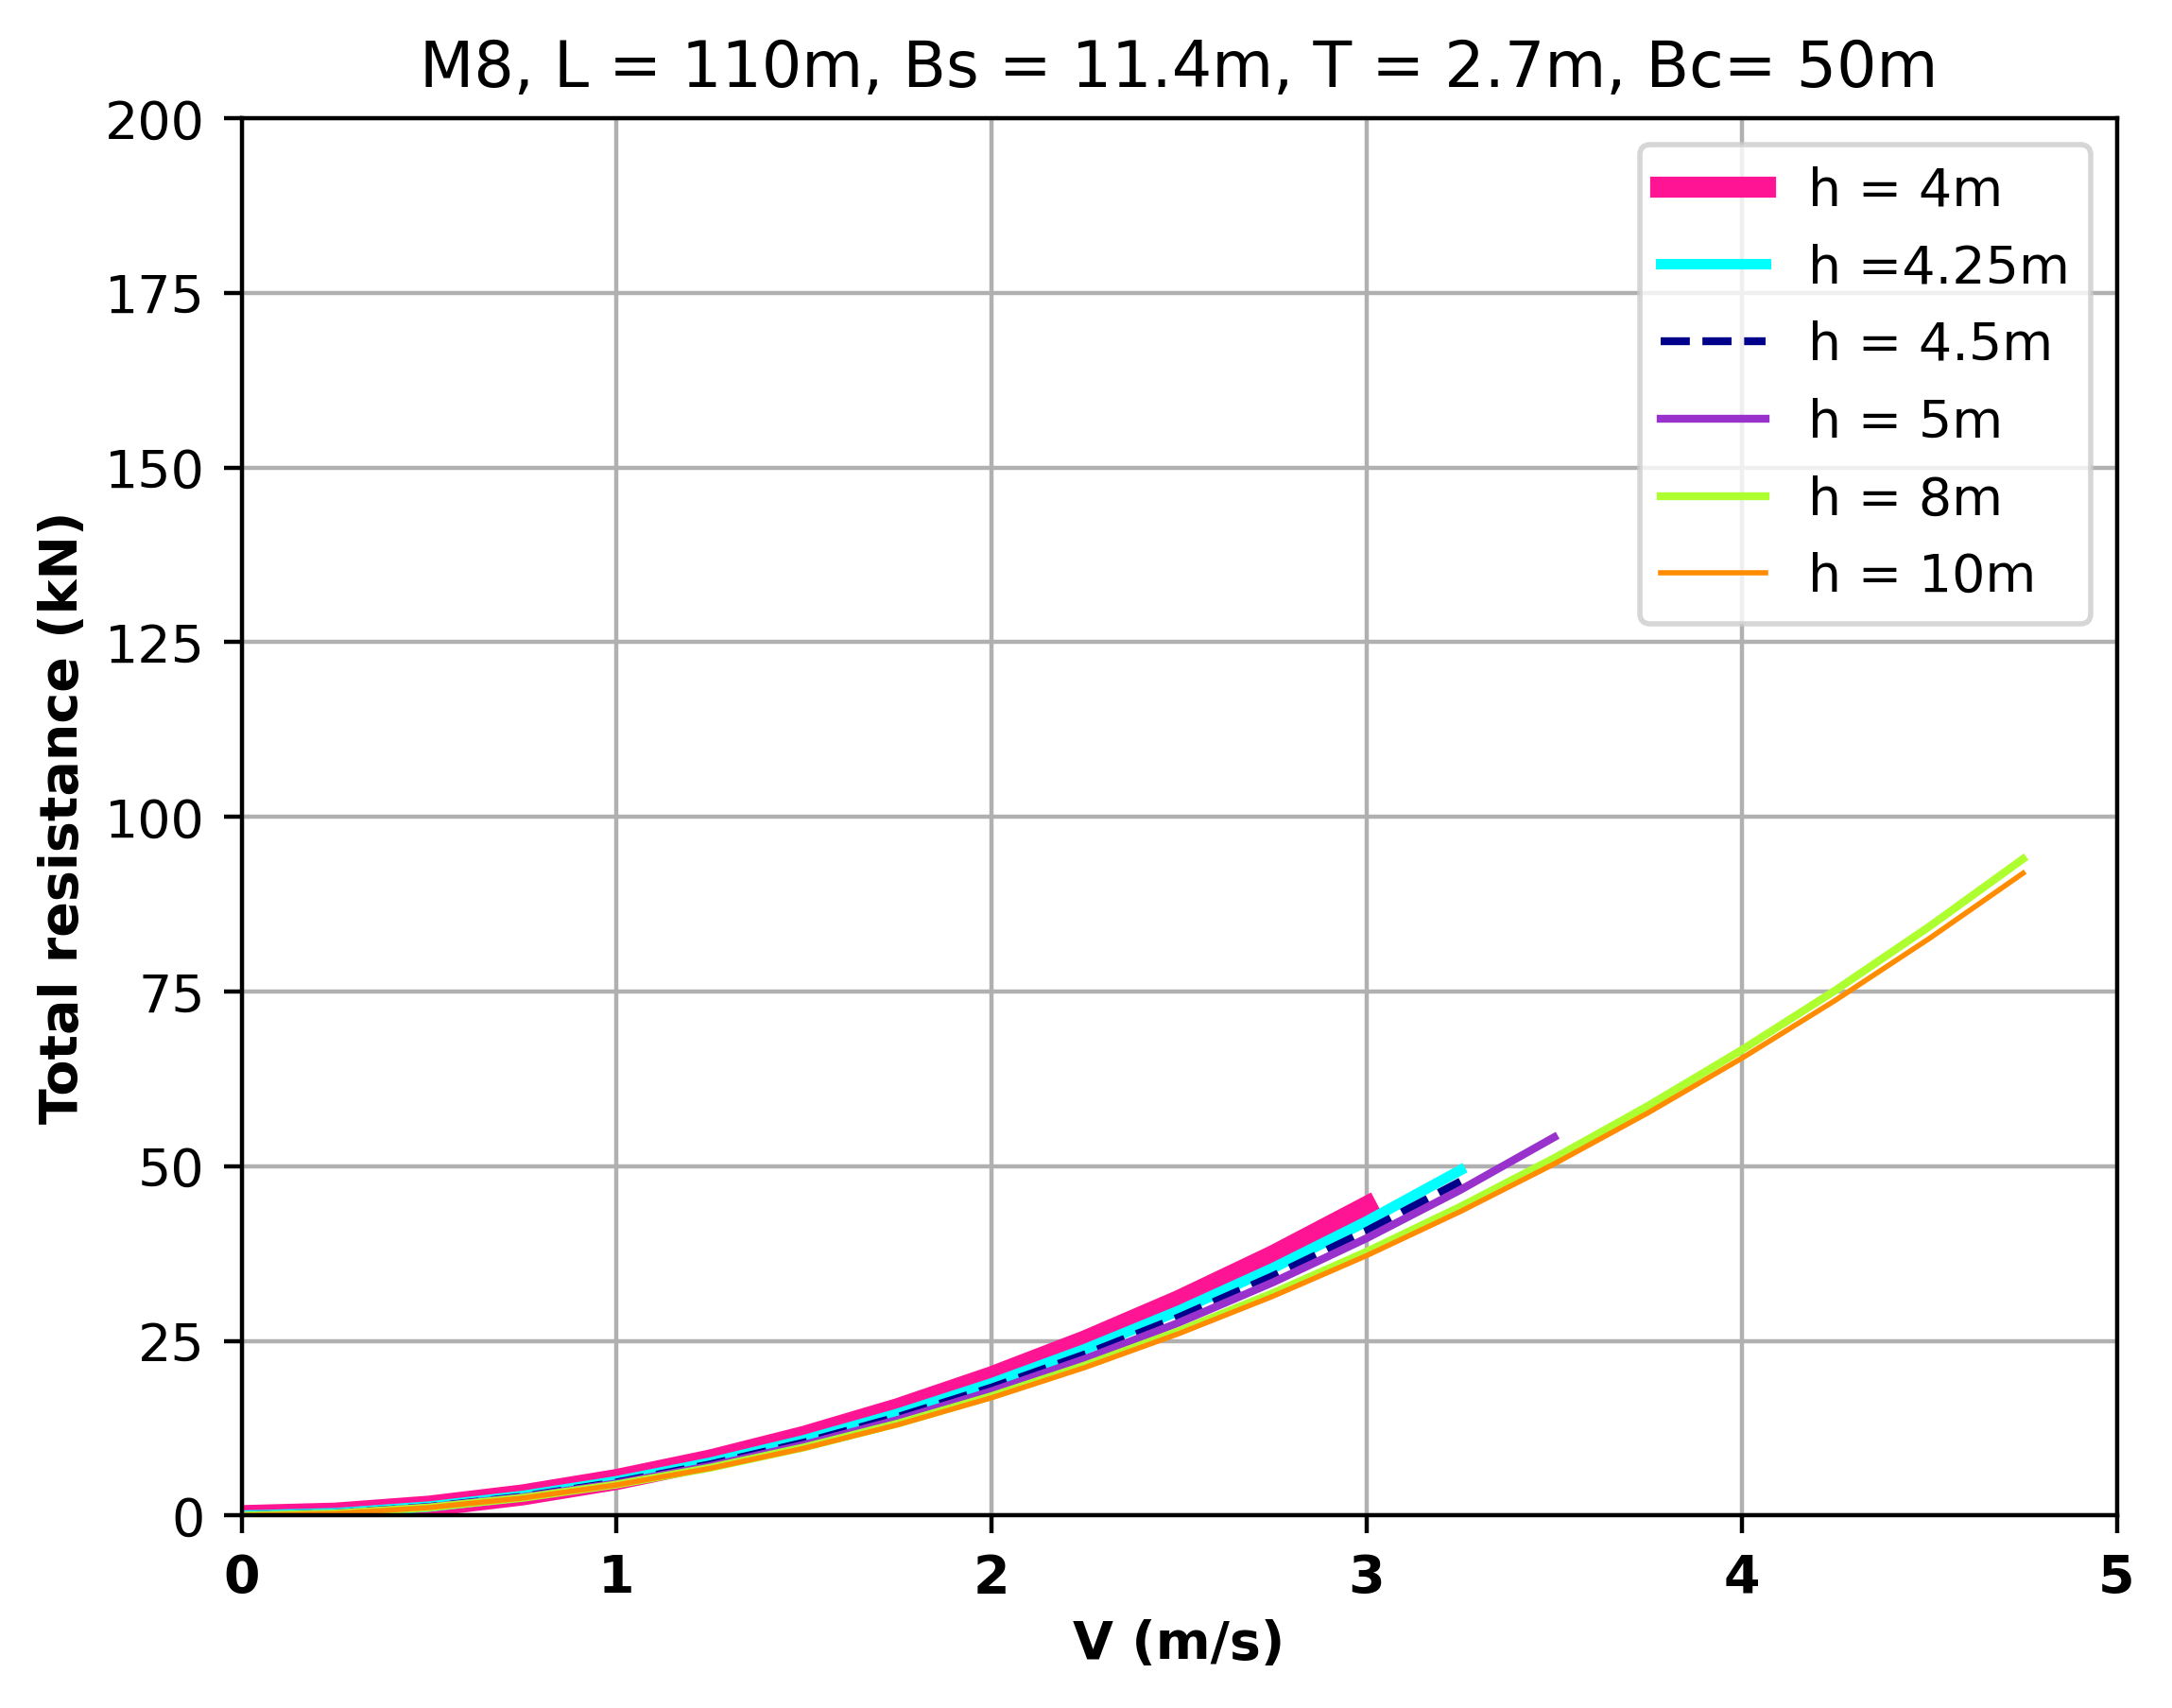

In [7]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Rtot'], 'deeppink', linewidth = 4)
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Rtot'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rtot'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Rtot'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Rtot'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Rtot'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Total resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.savefig('M8-Bolt Rtot-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

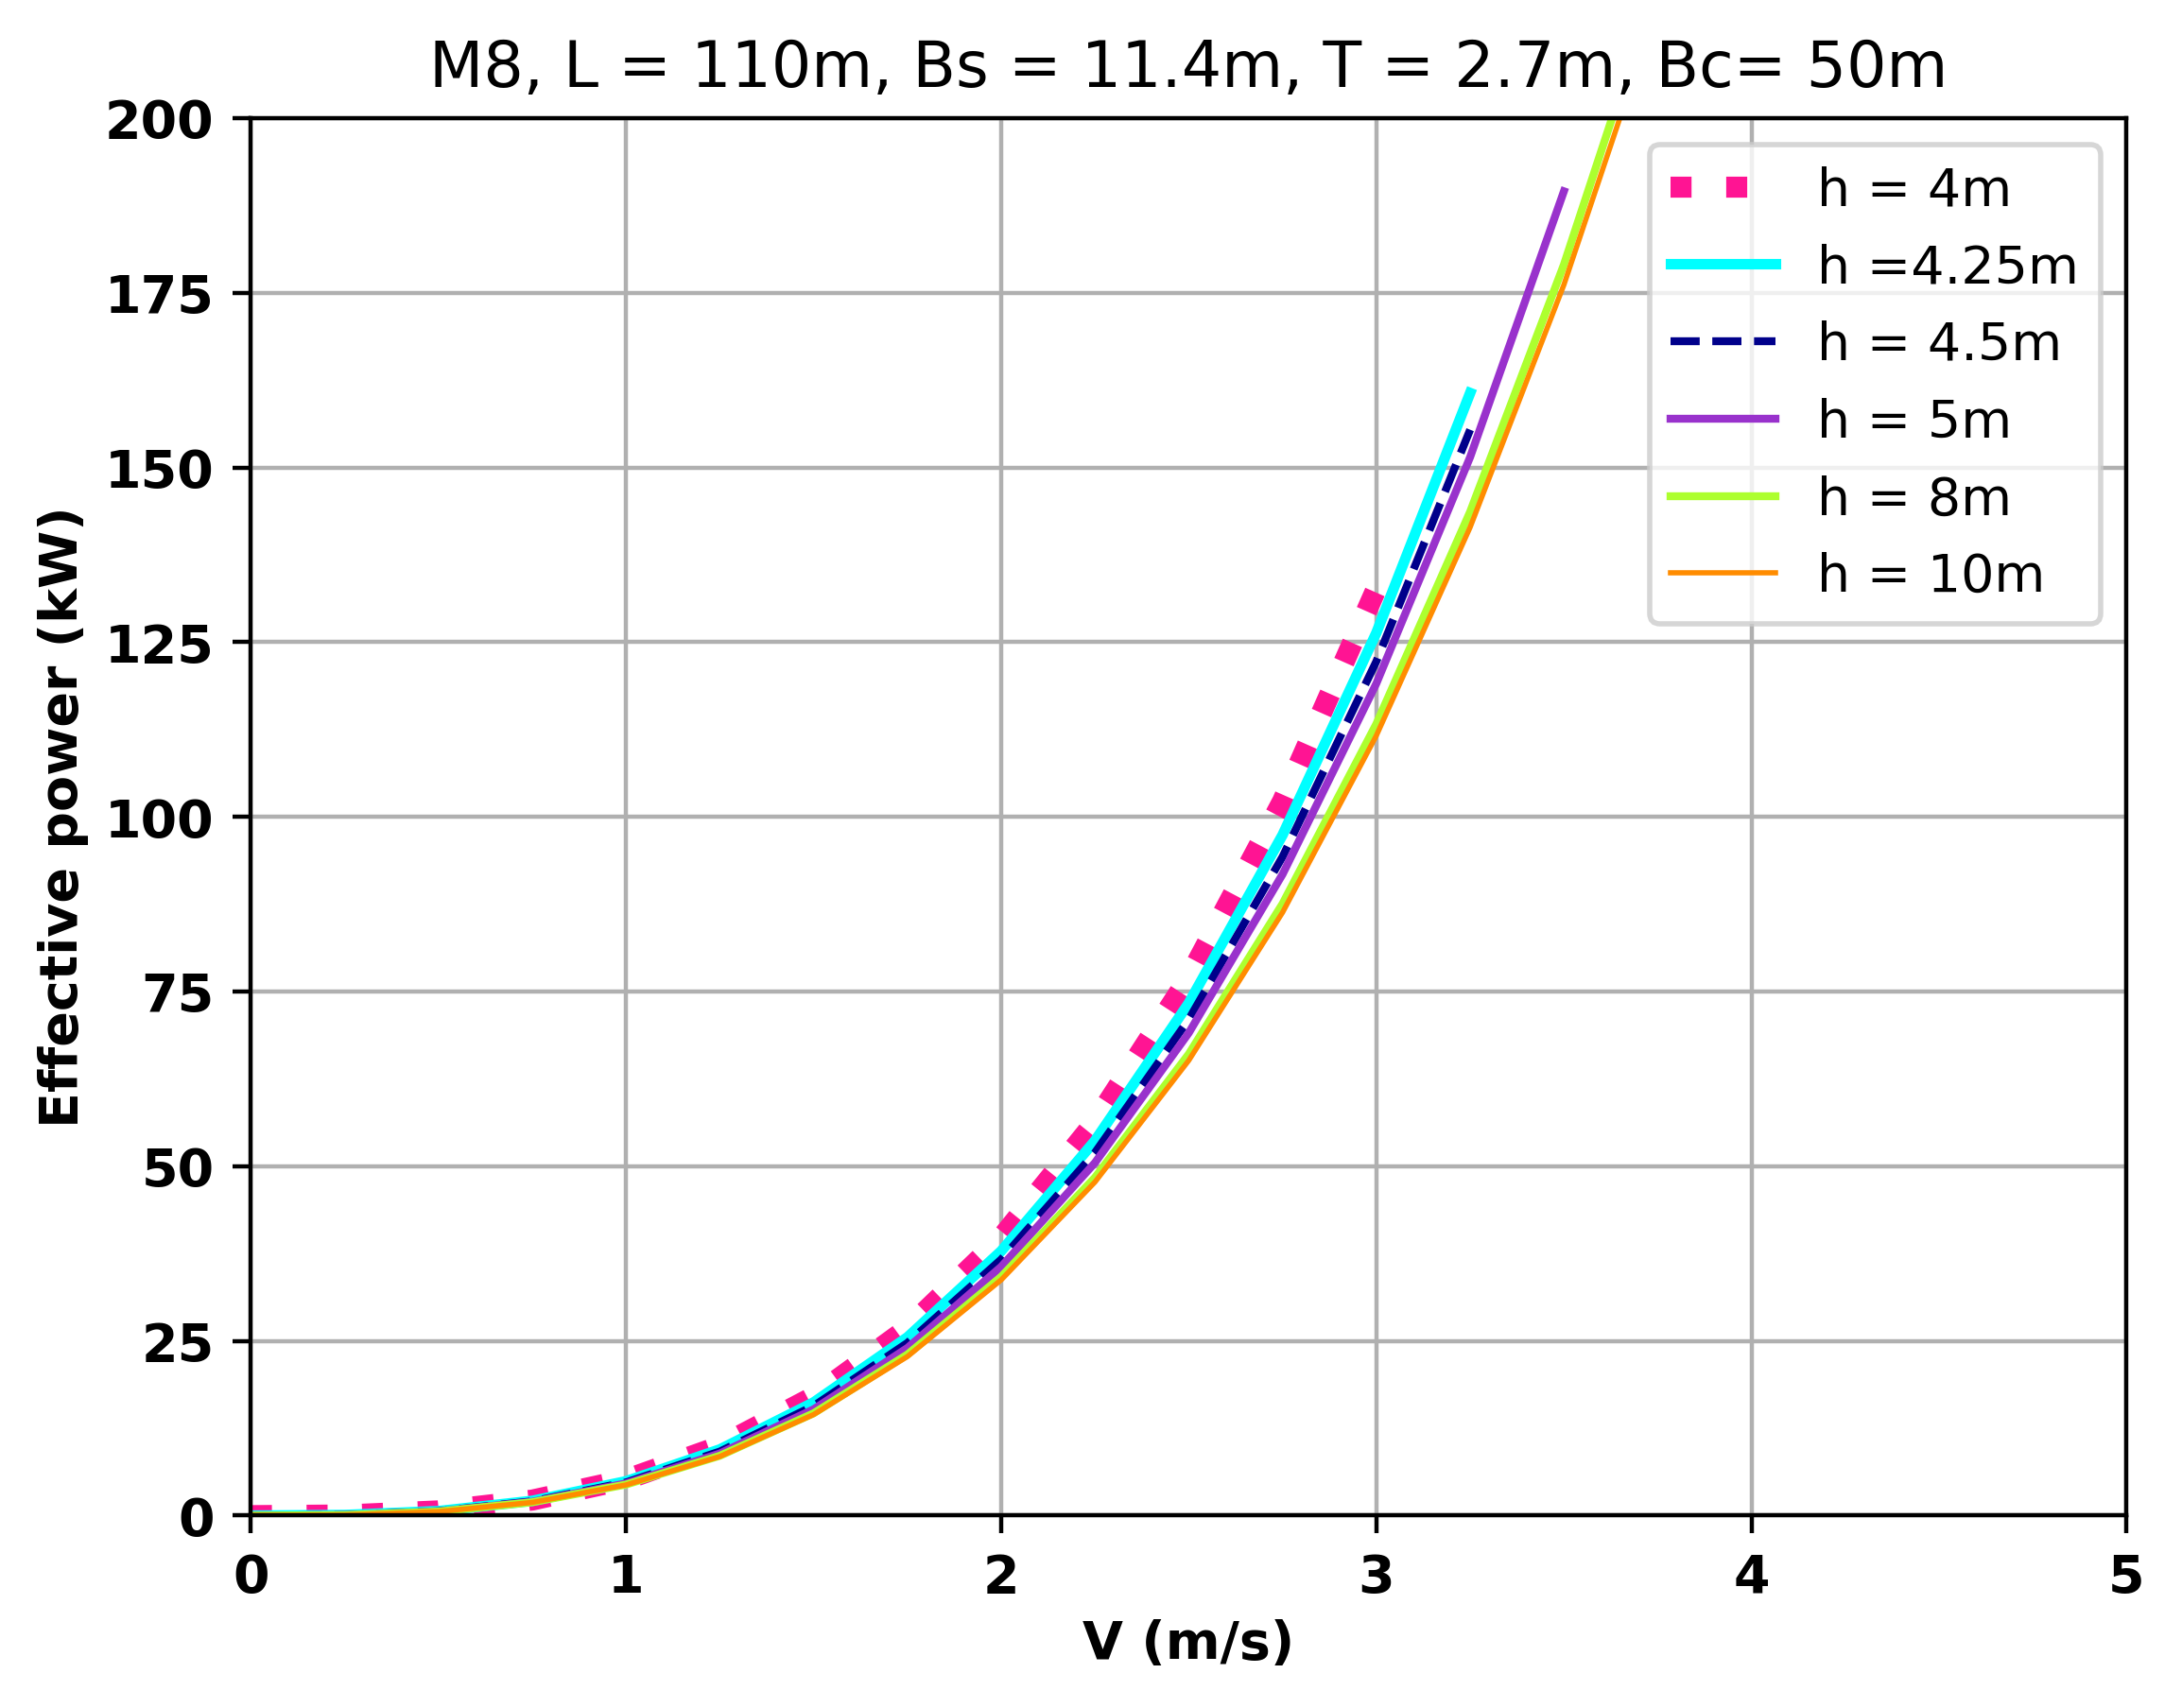

In [8]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pe'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pe'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pe'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pe'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pe'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pe'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Effective power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Bolt Pe-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

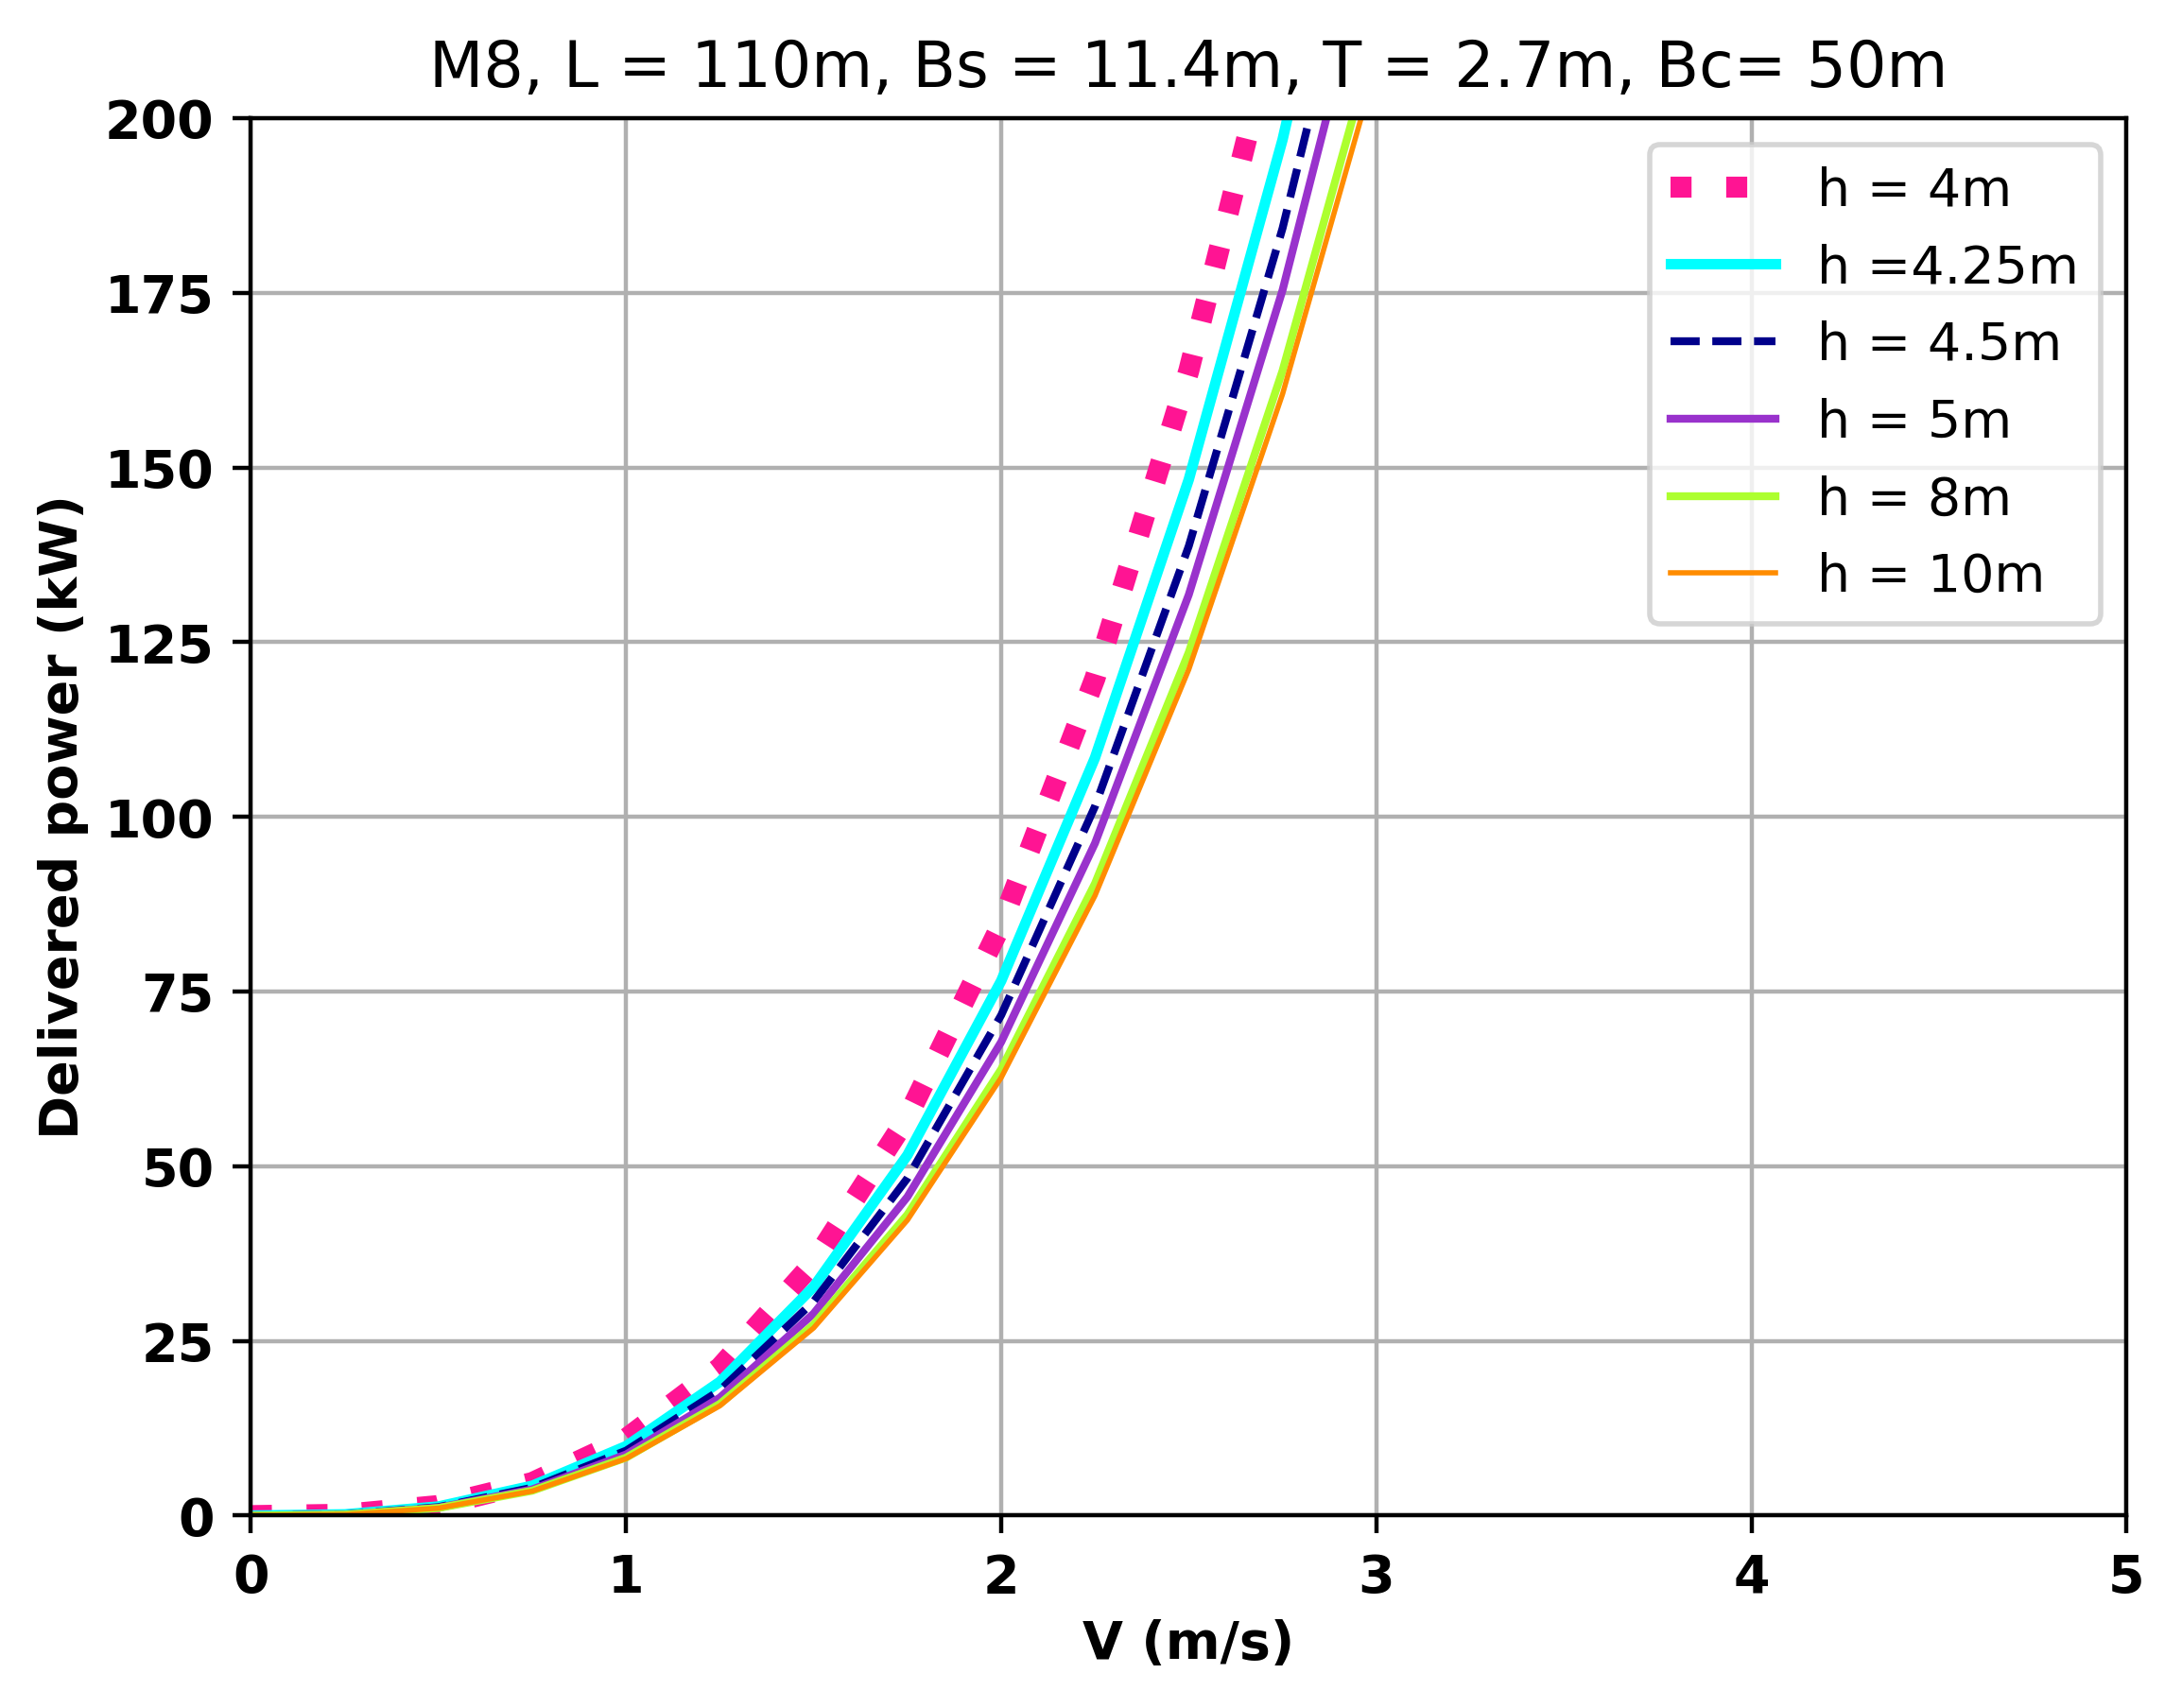

In [9]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')


plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pd'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pd'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pd'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pd'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Delivered power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Bolt Pd-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 150m')

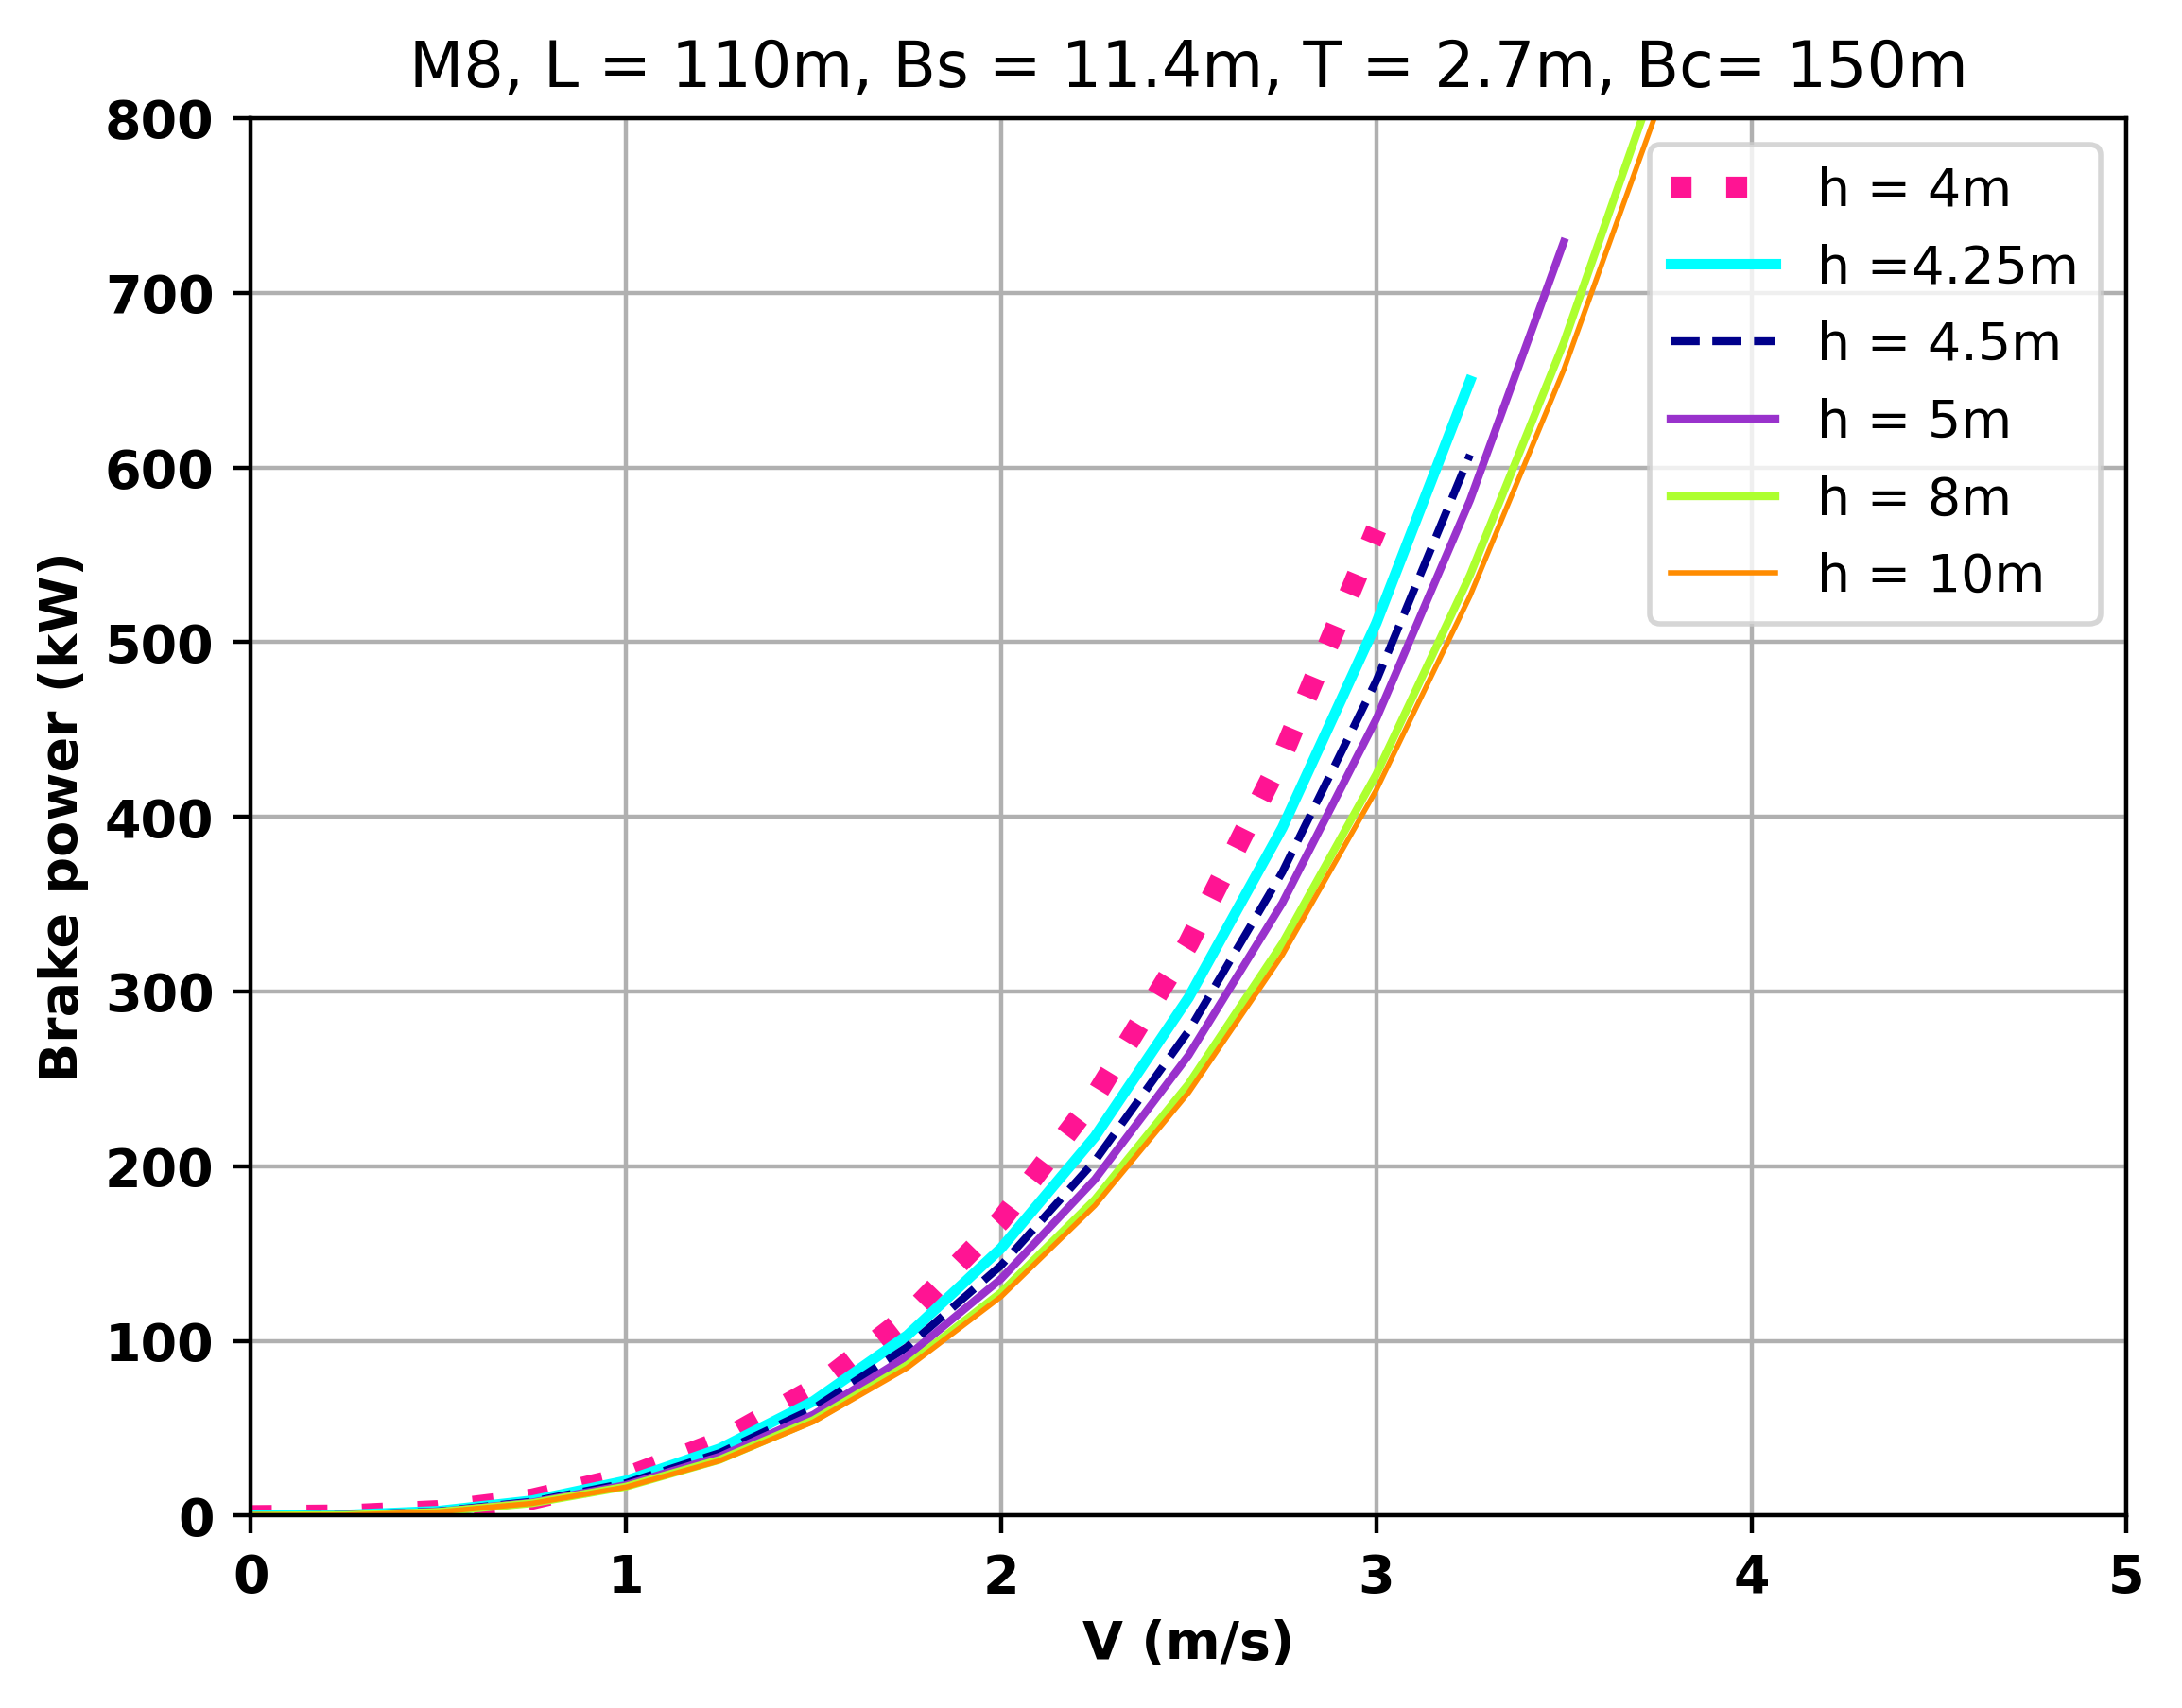

In [10]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pb'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pb'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pb'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pb'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pb'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pb'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,800)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Brake power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('w-M8-Bolt Pb-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 150m')